# Bulldozer Price Prediction

## Modules

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Initialize the dataframe

#### Parsing dates

In [126]:
train_df = pd.read_csv('assets/Train.csv', low_memory=False, parse_dates=['saledate'])
train_df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

In [128]:
for column in train_df.columns:
    unique_values = train_df[column].unique()
    print(f"Unique values in {column}: {len(unique_values)}")

Unique values in SalesID: 401125
Unique values in SalePrice: 899
Unique values in MachineID: 341027
Unique values in ModelID: 5218
Unique values in datasource: 5
Unique values in auctioneerID: 31
Unique values in YearMade: 72
Unique values in MachineHoursCurrentMeter: 15153
Unique values in UsageBand: 4
Unique values in saledate: 3919
Unique values in fiModelDesc: 4999
Unique values in fiBaseModel: 1950
Unique values in fiSecondaryDesc: 176
Unique values in fiModelSeries: 123
Unique values in fiModelDescriptor: 140
Unique values in ProductSize: 7
Unique values in fiProductClassDesc: 74
Unique values in state: 53
Unique values in ProductGroup: 6
Unique values in ProductGroupDesc: 6
Unique values in Drive_System: 5
Unique values in Enclosure: 7
Unique values in Forks: 3
Unique values in Pad_Type: 5
Unique values in Ride_Control: 4
Unique values in Stick: 3
Unique values in Transmission: 9
Unique values in Turbocharged: 3
Unique values in Blade_Extension: 3
Unique values in Blade_Width: 7

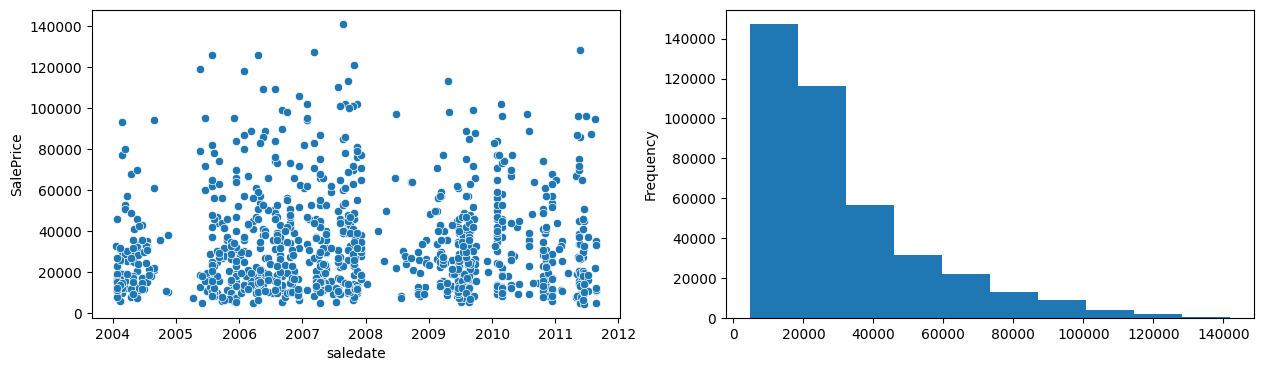

In [129]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# Extract individual axes
ax1, ax2 = ax.flatten()

sns.scatterplot(data=train_df[:1000], x='saledate', y='SalePrice', ax=ax1)
# ax1.set_xticks([])

# sns.histplot(data=df, x='SalePrice', ax=ax2, bins=20000)  
train_df.SalePrice.plot.hist()

plt.show()

#### Sorting the Dataframe by saledate

In [130]:
train_df.sort_values(by=['saledate'], inplace=True, ascending=True)
train_df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
92803,1404019,24000,1169900,7110,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98346,1415646,35000,1262088,3357,132,99.0,1975,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169297,1596358,19000,1433229,8247,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
274835,1821514,14000,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


## Data Cleaning

In [131]:
train_df.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    258360
UsageBand                   331486
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             137191
fiModelSeries               344217
fiModelDescriptor           329206
ProductSize                 210775
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                296764
Enclosure                      325
Forks                       209048
Pad_Type                    321991
Ride_Control                252519
Stick                       321991
Transmission                217895
Turbocharged                321991
Blade_Extension     

#### Filling missing values and converting object to numeric type

In [132]:
def dataWrangling(data):
    data['saleYear'] = data['saledate'].dt.year
    data['saleMonth'] = data['saledate'].dt.month
    data['saleDay'] = data['saledate'].dt.day

    data.drop(columns=['saledate'], inplace=True)
    
    obj_col = [column for column in data.columns if data[column].dtype == 'O'];
    
    label_encoder = LabelEncoder()
    data[obj_col] = data[obj_col].apply(label_encoder.fit_transform)
    
    features_with_missing_values = data.columns[data.isnull().any()].tolist()
    
    imputer = SimpleImputer(missing_values=np.nan, strategy="median", fill_value=None)
    
    imputer.fit(data[features_with_missing_values])
    
    data[features_with_missing_values] = imputer.transform(data[features_with_missing_values])

In [133]:
dataWrangling(train_df)

## Model Training

In [134]:
%%time
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

CPU times: total: 125 ms
Wall time: 138 ms


In [135]:
%%time
# instantiate model
model = RandomForestRegressor(n_jobs=-1, random_state=42)

# fit the model
model.fit(X, y)

CPU times: total: 25min 25s
Wall time: 7min 32s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [136]:
model.score(X, y) * 100

98.673488262426

This metric isnt reliable because we evaluated the model on the training set itself.

## Validating the model

#### Importing the validation set

In [137]:
valid = pd.read_csv('assets/Valid.csv', low_memory=False, parse_dates=['saledate'])
valid.head()

,SalePrice,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,31000.0,1222837,902859,1376,121,3,1000,0.0,NaN,2012-01-05,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
1,54000.0,1222839,1048320,36526,121,3,2006,4412.0,Medium,2012-01-05,...,None or Unspecified,"12' 4""",None or Unspecified,Yes,Double,NaN,NaN,NaN,NaN,NaN
2,26500.0,1222841,999308,4587,121,3,2000,10127.0,Medium,2012-01-05,...,None or Unspecified,"12' 4""",None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,10000.0,1222843,1062425,1954,121,3,1000,4682.0,Low,2012-01-05,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
4,35000.0,1222845,1032841,4701,121,3,2002,8150.0,Medium,2012-01-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


In [138]:
dataWrangling(valid)

In [139]:
valid.head()

,SalePrice,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay
0,31000.0,1222837,902859,1376,121,3,1000,0.0,3,293,...,1,0,1,8,7,3,3,2012,1,5
1,54000.0,1222839,1048320,36526,121,3,2006,4412.0,2,1611,...,2,0,1,8,7,3,3,2012,1,5
2,26500.0,1222841,999308,4587,121,3,2000,10127.0,2,160,...,1,0,1,8,7,3,3,2012,1,5
3,10000.0,1222843,1062425,1954,121,3,1000,4682.0,1,686,...,1,0,1,8,7,3,3,2012,1,5
4,35000.0,1222845,1032841,4701,121,3,2002,8150.0,2,397,...,3,2,1,8,7,2,1,2012,1,4


In [140]:
X_valid = valid.drop('SalePrice', axis=1)
y_valid = valid['SalePrice']

In [141]:
X_valid.shape, X.shape, y_valid.shape, y.shape

((11573, 54), (401125, 54), (11573,), (401125,))

#### Evaluation function

In [142]:
def rmsle(y_test, y_pred):
    """
    Calculates Root Mean Squared Log Error between predictions and true labels.
    """
    
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

def show_scores(model):
    train_pred = model.predict(X)
    val_pred = model.predict(X_valid)
    
    scores = {"Training MAE": mean_absolute_error(y, train_pred),
              "Valid MAE": mean_absolute_error(y_valid, val_pred),
              "Training RMSLE": rmsle(y, train_pred),
              "Valid RMSLE": rmsle(y_valid, val_pred),
              "Training R2": r2_score(y, train_pred),
              "Valid R2": r2_score(y_valid, val_pred)
             }
    
    return scores
    

#### change max samples value

In [143]:
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

In [144]:
%%time
# cutting down on the max number of samples
model.fit(X, y)

CPU times: total: 57.3 s
Wall time: 17.5 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [145]:
show_scores(model)

{'Training MAE': 5986.64457725148,
 'Valid MAE': 18440.96172297589,
 'Training RMSLE': 0.2764997314468187,
 'Valid RMSLE': 0.7677342763688118,
 'Training R2': 0.8378288436287179,
 'Valid R2': 0.23741454615002222}

### Hyperparameter tuning

In [146]:
rf_grid = {'n_estimators': np.arange(10, 100, 10),
          'max_depth': [None, 3, 5, 10],
          'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2),
           'max_features': [0.5, 1, 'sqrt', 'auto'],
           'max_samples': [10000]
          }

# instantiate RSCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True
                             )

# fit the RSCV model
rs_model.fit(X, y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [147]:
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 16,
 'min_samples_leaf': 5,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [148]:
# Evaluate the RSCV model
show_scores(rs_model)

{'Training MAE': 6367.950566949183,
 'Valid MAE': 16495.054994180286,
 'Training RMSLE': 0.2877550424981583,
 'Valid RMSLE': 0.6839366616119151,
 'Training R2': 0.8189969273147146,
 'Valid R2': 0.3696321747888006}

#### Train a model with the best hyperparameter

In [149]:
%%time

# most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                   min_samples_split=14,
                                   max_features=0.5,
                                   n_jobs=-1,
                                   max_samples=None,
                                   random_state=42)

# fit the ideal model
ideal_model.fit(X, y)

CPU times: total: 4min 25s
Wall time: 1min 17s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [150]:
show_scores(ideal_model)

{'Training MAE': 3046.8762241390996,
 'Valid MAE': 16219.615222774635,
 'Training RMSLE': 0.14813741319882642,
 'Valid RMSLE': 0.6494212409474074,
 'Training R2': 0.9563831995220027,
 'Valid R2': 0.3717422227377646}

## Evaluate the model using Test set

In [151]:
test = pd.read_csv('assets/Test.csv', low_memory=False, parse_dates=['saledate'])
test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [152]:
dataWrangling(test)

In [153]:
test_pred = ideal_model.predict(test)

In [154]:
df_pred = pd.DataFrame()
df_pred['SalesID'] = test['SalesID']
df_pred['SalesPrice'] = test_pred

df_pred.head()

,SalesID,SalesPrice
0,1227829,25952.961482
1,1227844,28839.306851
2,1227847,54626.744616
3,1227848,50199.870385
4,1227863,40418.338452
